# **Práctica 1**: Clasificación de competencia lingüística en composiciones de L2


In [ ]:
# opcional: puedes montar el Drive o subir los datos
from google.colab import drive
drive.mount('/content/drive')

En este tutorial vamos a entrenar un modelo de clasificación que nos permita predecir la competencia lingüística del estudiante de español basado en sus composiciones de escritura asignados en clase. 

In [2]:
# importamos las librerias y sus módulos
import numpy as np
import pandas as pd 

from collections import Counter
import matplotlib.pyplot as plt

!pip install sklearn
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

In [ ]:
# opcional: nos permite ver en qué directorio estamos
import os
os.getcwd()

'/content'

In [3]:
# leemos nuestro archivo de csv y asignamos los nombres de la columnas que queremos importar.
import csv
fields=["Text", "Proficiency"]

df = pd.read_csv('/content/cedel2.csv', encoding="latin-1", usecols=fields)

text=df["Text"]
label=df["Proficiency"]

In [5]:
# pasamos los datos seleccionados a una nueva tabla o dataframe
corpus = pd.DataFrame()
corpus['text'] = text
corpus['label'] = label

# podemos guardar si deseamos
#corpus.to_csv('L2Comps.csv', index=None) # Guardamos!

In [6]:
# verificamos que las columnas estén asignadas correctamente
text[21], label[21]

('En el videoclip, hay un hombre (Charlie Chaplin) que marcha en la calle, tranquilo. El encuentre a un bebe cerca de la basura, abandonado. Cree que el bebe es el hijo de una mujer que camine en la calle con su proprio bebe, pero, este no fue correcto. Despu\x8es, pruebe a poner el bebe otra vez cerca de la basura, pero un (policeman) lo prohib\x92 de hacer este. Entonces, Chaplin dio el bebe a un otro hombre en la calle y este hombre poni el bebe en la (babycart) de la mujer de antes. Ella estaba muy emojonada y dio el bebe a Chaplin otra vez. Sin saber que hacer, Chaplin se sentado con el bebe, desesperado, y encuentre a una carta en la ropa del bebe. En esta carta se escrib\x92: "Ten cuidado y ama este orfano bebe por favor".',
 'Upper intermediate')

In [8]:
# veamos la estructura de nuestros datos
print('Shape of Corpus is {}'.format(df.shape))

Shape of Corpus is (3034, 2)


In [9]:
# veamos cuantos features o labels hay
corpus["label"].value_counts()

Lower advanced        764
Upper intermediate    679
Lower intermediate    548
Upper beginner        529
Upper advanced        421
Lower beginner         93
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


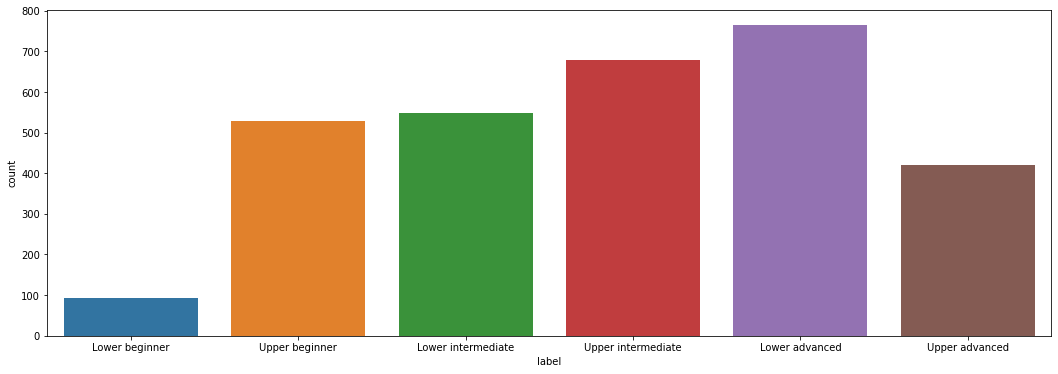

In [11]:
# visualizamos
import seaborn as sns
fig2 = plt.figure(figsize=(18,6))
sns.countplot(corpus['label']);

### Dividimos los datos entre train (70%) y test (30%)

In [12]:
from sklearn import model_selection

train_text, test_text, train_label, test_label = model_selection.train_test_split(corpus['text'],
                                                                                  corpus['label'],
                                                                                  test_size=0.33)

In [13]:
print(train_text[:2])

1042    El video fue solo en blanco y negro. Un hombre...
805     En el verano pasado, yo fue a la playa con mi ...
Name: text, dtype: object


In [14]:
print(test_text[:2])

1861    En septiembre del ao pasado, fuimos mi mujer ...
348     Mi persona favorita es Tim McGraw. Tim McGraw ...
Name: text, dtype: object


### Estandarizamos para cumplir con la distribución normal de los datos: una curva en forma de campana. Luego Transformamos los datos en vectores 

In [15]:
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()

In [16]:
# notemos la distribución sin transformar
print(test_label[:10])

1861        Upper advanced
348         Upper beginner
1598        Lower advanced
1984        Upper advanced
26      Upper intermediate
868     Lower intermediate
643     Lower intermediate
966     Upper intermediate
1451        Lower advanced
2839    Upper intermediate
Name: label, dtype: object


In [17]:
train_label = encoder.fit_transform(train_label)
test_label = encoder.fit_transform(test_label)

In [25]:
# ahora veamos la distribución centrada alrededor del variance
print(test_label[:10])

[3 4 0 3 5 2 2 5 0 5]


In [26]:
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
# Vectorización: transformación numérica del texto
vectorizer = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
vectorizer.fit(corpus['text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='\\w{1,}', tokenizer=None,
                vocabulary=None)

In [28]:
# vectorizamos
train_text_count = vectorizer.transform(train_text)
test_text_count = vectorizer.transform(test_text)

## Entrenamiento del clasificador

Para esta práctica vamos a probar con tres tipos de métodos estadísticos:

1. regresión lineal
2. estadística bayesiana
3. tf-idf

Todos estos modelos estadísticos hacen parte de Support Vector Machines. 

In [29]:
# 1. regresión lineal
from sklearn import linear_model

In [30]:
classifier = linear_model.LogisticRegression(solver='liblinear')
classifier.fit(train_text_count, train_label)
predictions = classifier.predict(test_text_count)

In [31]:
from sklearn import metrics

In [32]:
# evaluamos la precisión
accuracy = metrics.accuracy_score(predictions, test_label)
print("LR, Count Vectors: ", accuracy)

LR, Count Vectors:  0.4161676646706587


In [33]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_train_res, y_train_res = sm.fit_sample(train_text_count, train_label)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [34]:
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))

[(0, 530), (1, 530), (2, 530), (3, 530), (4, 530), (5, 530)]


In [35]:
#2 Naive Bayes: estadística bayesiana

from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_res, y_train_res)
nb.score(X_train_res, y_train_res) #This is the fit score, not the actual accuracy score

0.7150943396226415

In [36]:
X_test_vect = vectorizer.transform(test_text)
y_pred = nb.predict(X_test_vect)
y_pred

array([3, 4, 5, ..., 3, 5, 0])

In [38]:
#Evaluación más compleja
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(test_label, y_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(test_label, y_pred, average='micro') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(test_label, y_pred))

Accuracy: 36.63%

F1 Score: 36.63

Confusion Matrix:
 [[ 78   0   1 114   0  41]
 [  3   0   2   7  15   1]
 [ 34   1  55  23  17  56]
 [ 54   0   0  85   0   8]
 [ 16   2  48  19  84  27]
 [ 73   0  21  52   0  65]]


In [39]:
from sklearn.model_selection import ShuffleSplit

X = corpus['text']
y = corpus['label']

ss = ShuffleSplit(n_splits=10, test_size=0.2)
sm = SMOTE()

accs = []
f1s = []
cms = []

for train_index, test_index in ss.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit vectorizer and transform X train, then transform X test
    X_train_vect = vectorizer.fit_transform(X_train)
    X_test_vect = vectorizer.transform(X_test)
    
    # Oversample
    X_train_res, y_train_res = sm.fit_sample(X_train_vect, y_train)
    
    # Fit Naive Bayes on the vectorized X with y train labels, 
    # then predict new y labels using X test
    nb.fit(X_train_res, y_train_res)
    y_pred = nb.predict(X_test_vect)
    
    # Determine test set accuracy and f1 score on this fold using the true y labels and predicted y labels
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred, average='micro'))
    cms.append(confusion_matrix(y_test, y_pred))
    
print("\nAverage accuracy across folds: {:.2f}%".format(sum(accs) / len(accs) * 100))
print("\nAverage F1 score across folds: {:.2f}%".format(sum(f1s) / len(f1s) * 100))
print("\nAverage Confusion Matrix across folds: \n {}".format(sum(cms) / len(cms)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni


Average accuracy across folds: 39.06%

Average F1 score across folds: 39.06%

Average Confusion Matrix across folds: 
 [[66.7  0.   2.  62.5  0.  25.9]
 [ 1.7  0.7  2.7  1.7 12.1  1.5]
 [24.   0.1 32.   8.8 10.8 31.4]
 [28.9  0.   0.1 48.1  0.   5.9]
 [ 9.9  1.5 20.8  5.5 48.5 15.7]
 [56.9  0.  13.6 24.8  1.1 41.1]]


### Prueba: veamos que tan preciso es nuestro modelo para predecir la competencia con datos reales

In [40]:
# vectorizamos una oración

#sentence = vectorizer.transform(['Antes vine un Indiana University, pensé quería estudiar justicia penal pero Las ciencias de políticas es mi deseo. A preparar para clase, me aseguro mi escritorio, tengo mi monitor y torre computadora cual uso para la tarea, pero a veces soy miren películas y programas es cercano. Tambien in my tiempo libre, fui a gimnasio y hacer ejercicio y a veces nadar. Después, ver la televisión y dormir.'])
#sentence = vectorizer.transform(['Yo juego con mi amigo en el parque.'])
sentence = vectorizer.transform(['Una persona famosa es Justin Bieber. El cumpleaños de Justin es el primero de Marzo y tiene 22 años.  Justin es de Canadá y es un cantante y guitarrista. Él se hizo su primo álbum de música en 2008, "My World". Justin hizo cuatro álbumes de músicas. Sus cantas famosas son “Baby” “Never Say Never” y “Sorry.” Justin, también hizo un álbum de Navidad música. Fui al concierto de su en 2011. Mi canción favorito es “Purpose” porque Justin es dando gracias a sus fanáticos. Me enamorado Justin porque él es muy guapo y cantas bien. Pero se enamorada con Sofía Richie. Sofía es la nueva de Justin y tiene 18 años. Justin es muy popular porque estaba saliendo Selena Gomez por sobre cuatro años y sus separación fue muy mal. Ustedes estaban enamorar pero está bien porque yo casaré con Justin.'])

label_prediction = nb.predict(sentence)
prob = nb.predict_proba(sentence)
#print(corpus['label'].value_counts().sort_index())
print(label_prediction[0], prob * 100) #The array shows the probs for all the labels ordered by the label of classes

Upper beginner [[5.95791524e-30 2.37575058e-04 2.07679009e-12 3.68181014e-32
  9.99997624e+01 2.35332482e-10]]


---

In [41]:
# 3. tf-idf: "a statistical measure that evaluates how relevant a word is to a document in a collection of documents. "

from sklearn.naive_bayes import MultinomialNB
cls = MultinomialNB()
# transform the list of text to tf-idf before passing it to the model
cls.fit(vectorizer.transform(train_text), train_label)
 
from sklearn.metrics import classification_report, accuracy_score
 
y_pred = cls.predict(vectorizer.transform(test_text))
print(accuracy_score(test_label, y_pred))
print(classification_report(test_label, y_pred))

0.3972055888223553
              precision    recall  f1-score   support

           0       0.34      0.74      0.47       234
           1       0.00      0.00      0.00        28
           2       0.44      0.25      0.32       186
           3       0.48      0.19      0.27       147
           4       0.72      0.40      0.51       196
           5       0.33      0.35      0.34       211

    accuracy                           0.40      1002
   macro avg       0.38      0.32      0.32      1002
weighted avg       0.44      0.40      0.38      1002



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
#sentence = vectorizer.transform(['Yo no jugar .'])
#sentence = vectorizer.transform(['Antes vine un Indiana University, pensé quería estudiar justicia penal pero Las ciencias de políticas es mi deseo. A preparar para clase, me aseguro mi escritorio, tengo mi monitor y torre computadora cual uso para la tarea, pero a veces soy miren películas y programas es cercano. Tambien in my tiempo libre, fui a gimnasio y hacer ejercicio y a veces nadar. Después, ver la televisión y dormir.'])
sentence = vectorizer.transform(['Una persona famosa es Justin Bieber. El cumpleaños de Justin es el primero de Marzo y tiene 22 años.  Justin es de Canadá y es un cantante y guitarrista. Él se hizo su primo álbum de música en 2008, "My World". Justin hizo cuatro álbumes de músicas. Sus cantas famosas son “Baby” “Never Say Never” y “Sorry.” Justin, también hizo un álbum de Navidad música. Fui al concierto de su en 2011. Mi canción favorito es “Purpose” porque Justin es dando gracias a sus fanáticos. Me enamorado Justin porque él es muy guapo y cantas bien. Pero se enamorada con Sofía Richie. Sofía es la nueva de Justin y tiene 18 años. Justin es muy popular porque estaba saliendo Selena Gomez por sobre cuatro años y sus separación fue muy mal. Ustedes estaban enamorar pero está bien porque yo casaré con Justin.'])

label_prediction = cls.predict(sentence)
prob = cls.predict_proba(sentence)
print(corpus['label'].value_counts().sort_index())
print(label_prediction[0], prob * 100) #The array shows the probs for all the labels ordered by the label of classes

Lower advanced        764
Lower beginner         93
Lower intermediate    548
Upper advanced        421
Upper beginner        529
Upper intermediate    679
Name: label, dtype: int64
4 [[1.15512124e-27 2.68002812e-51 5.88333703e-12 9.20696048e-29
  9.99999997e+01 3.46319875e-07]]


El label 4 corresponde a Upper Advanced

### Comparación de modelos

---

In [44]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score
 
# start with the classic
# with either pure counts or tfidf features
sgd = Pipeline([
        ("count vectorizer", CountVectorizer(stop_words="english", max_features=3000)),
        ("sgd", SGDClassifier(loss="modified_huber"))
    ])
sgd_tfidf = Pipeline([
        ("tfidf_vectorizer", TfidfVectorizer(stop_words="english", max_features=3000, lowercase=False)),
        ("sgd", SGDClassifier(loss="modified_huber"))
    ])
 
svc = Pipeline([
        ("count_vectorizer", CountVectorizer(stop_words="english", max_features=3000)),
        ("linear svc", SVC(kernel="linear"))
    ])
svc_tfidf = Pipeline([
        ("tfidf_vectorizer", TfidfVectorizer(stop_words="english", max_features=3000, lowercase=False)),
        ("linear svc", SVC(kernel="linear"))
    ])
   
all_models = [
    ("sgd", sgd,),
    ("sgd_tfidf", sgd_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
    ]
 
unsorted_scores = [(name, cross_val_score(model, train_text, train_label, cv=2).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])
print(scores)

[('svc_tfidf', 0.43700787401574803), ('svc', 0.4183070866141732), ('sgd_tfidf', 0.39074803149606296), ('sgd', 0.3853346456692913)]


Parece que el clasificador SVC_tfidf es el más preciso para estos datos con múltiples labels. Así que lo utilizaremos.

In [45]:
#model = sgd_tfidf
model = svc_tfidf
model.probability = True
model.fit(train_text, train_label)
y_pred = model.predict(test_text)
print(accuracy_score(test_label, y_pred))
print(classification_report(test_label, y_pred))

0.4560878243512974
              precision    recall  f1-score   support

           0       0.40      0.65      0.49       234
           1       0.00      0.00      0.00        28
           2       0.47      0.36      0.41       186
           3       0.49      0.23      0.31       147
           4       0.62      0.62      0.62       196
           5       0.38      0.40      0.39       211

    accuracy                           0.46      1002
   macro avg       0.40      0.38      0.37      1002
weighted avg       0.46      0.46      0.44      1002



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
#sentence = (['Antes vine un Indiana University, pensé quería estudiar justicia penal pero Las ciencias de políticas es mi deseo. A preparar para clase, me aseguro mi escritorio, tengo mi monitor y torre computadora cual uso para la tarea, pero a veces soy miren películas y programas es cercano. Tambien in my tiempo libre, fui a gimnasio y hacer ejercicio y a veces nadar. Después, ver la televisión y dormir.'])
#sentence = (['!Tengo ser actriz! Jennifer López y Christina Milian es muy bonita. Jennifer es muy bueño actriz. Yo quiero ser como Jennifer López. Christian Milian es más o meños.'])
#sentence = (['Una persona famosa es Justin Bieber. El cumpleaños de Justin es el primero de Marzo y tiene 22 años.  Justin es de Canadá y es un cantante y guitarrista. Él se hizo su primo álbum de música en 2008, "My World". Justin hizo cuatro álbumes de músicas. Sus cantas famosas son “Baby” “Never Say Never” y “Sorry.” Justin, también hizo un álbum de Navidad música. Fui al concierto de su en 2011. Mi canción favorito es “Purpose” porque Justin es dando gracias a sus fanáticos. Me enamorado Justin porque él es muy guapo y cantas bien. Pero se enamorada con Sofía Richie. Sofía es la nueva de Justin y tiene 18 años. Justin es muy popular porque estaba saliendo Selena Gomez por sobre cuatro años y sus separación fue muy mal. Ustedes estaban enamorar pero está bien porque yo casaré con Justin.'])
sentence = (['Actualmente yo vivo en una zona de Madrid que es poca conocida ya que la acaban de construir, se llama Las Tablas. Está en el norte de Madrid entre el pueblo de Fuencarral y Alcobendas. Vivo alli con mi esposa e hija de nueve meses y estamos bastantes contentos alli aunque hay unos puntos que deberian cambiar lo antes posible. Estuvimos esperando mucho tiempo para la entrega de las llaves de nuestro piso nuevo que finalmente efectuaron el diciembre pasado. Desde entonces llevamos unos meses difíciles en los que hemos estado ententando preparar la vivienda, compra todos los muebles nuevos, organizar la instalación de la cocina, alisar y pintar las paredes (eran de gotelé) y trasladar todo lo necesario desde nuestro piso antiguo. Estamos viviendo alli desde el princípio de marzo pero hemos pasado de un tiempo un poco estresante para conseguir una vivienda digna.'])
label_prediction = model.predict(sentence)

#prob = model.predict_proba(sentence)
print(corpus['label'].value_counts().sort_index())
print(label_prediction[0], prob * 100) 
#The array shows the probs for all the labels ordered by the label of classes. Remember that the index start with 0.

Lower advanced        764
Lower beginner         93
Lower intermediate    548
Upper advanced        421
Upper beginner        529
Upper intermediate    679
Name: label, dtype: int64
0 [[1.15512124e-27 2.68002812e-51 5.88333703e-12 9.20696048e-29
  9.99999997e+01 3.46319875e-07]]


El label 0 corresponde a Lower Advanced

---